In [19]:
import pandas as pd
import numpy as np
import h5py

In [3]:
test = pd.read_hdf('test.h5','data')
train = pd.read_hdf('train.h5','data')

In [4]:
alldata = pd.concat([train,test],axis=0)
print(alldata.shape)

(422126, 6)


In [14]:
eventInversemap = {5:'cart', 10:'purchase', -5:'remove_from_cart', 1:'view'}

In [17]:
times = 0
ag = alldata.groupby('product_id')
productsInfo = np.zeros(len(ag),dtype=[('view','<i4'),('cart','<i4'),('remove_from_cart','<i4'),('purchase','<i4'),('cart-view','<f4'),('purchase-cart','<f4'),('purchase-view','<f4')])
productsIndex = {}
for i,(product_id,ur) in enumerate(alldata.groupby('product_id')):
    ru = ur['event_type'].value_counts()
    for key in ru.keys():
        productsInfo[i][eventInversemap[key]] = ru[key]
    if productsInfo[i]['view']!=0:
        productsInfo[i]['cart-view'] = productsInfo[i]['cart']/productsInfo[i]['view']
        productsInfo[i]['purchase-view'] = productsInfo[i]['purchase']/productsInfo[i]['view']
    if productsInfo[i]['cart']!=0:
        productsInfo[i]['purchase-cart'] = productsInfo[i]['purchase']/productsInfo[i]['cart']
    productsIndex[product_id] = i

In [21]:
with h5py.File('product_info.h5','w') as opt:
    opt.create_dataset('info', data=productsInfo, compression='gzip')
    #opt.create_dataset('index', data=productsIndex,compression='gzip')
np.save('pindex.npy',productsIndex)

In [68]:

def maxtimeGroup(df):
    gr = df.groupby('user_id')
    predict = np.zeros(len(gr),dtype=[('user_id','<i4'),('product_id','<i4')])
    for i,(user_id, ur) in enumerate(gr):
        r,ri, rc = np.unique(ur[['product_id']][::-1],return_counts=True,return_index=True)
        selectur = ur[['event_time','product_id']][::-1].iloc[ri]
        selectur['count'] = rc
        sur = np.sort(selectur.to_records(index=False),order=['count','event_time'])
        predict[i] = (user_id, sur[-1]['product_id'])
    return predict

In [69]:
predict = maxtimeGroup(test)

In [53]:
def lasttimeGroup(df):
    gr = df.groupby('user_id')
    predict = np.zeros(len(gr),dtype=[('user_id','<i4'),('product_id','<i4')])
    for i,(user_id, ur) in enumerate(gr):
        predict[i] = (user_id, ur.iloc[-1]['product_id'])
    return predict

In [70]:
pd.DataFrame(predict).to_csv('item.csv',index=False)

In [54]:
lastpredict=lasttimeGroup(test)

In [55]:
pd.DataFrame(lastpredict).to_csv('item1.csv',index=False)

In [75]:
def maxtimeGradeGroup(df):
    gr = df.groupby('user_id')
    predict = np.zeros(len(gr),dtype=[('user_id','<i4'),('product_id','<i4')])
    for i,(user_id, ur) in enumerate(gr):
        r,ri, rc = np.unique(ur[['product_id']][::-1],return_counts=True,return_index=True)
        grade = ur.groupby('product_id')['event_type'].sum()
        selectur = ur[['event_time','product_id']][::-1].iloc[ri]
        selectur['count'] = rc
        selectur = selectur.merge(grade,on='product_id')
        sur = np.sort(selectur.to_records(index=False),order=['event_type','event_time','count'])
        
        predict[i] = (user_id, sur[-1]['product_id'])
    return predict

In [ ]:
test.loc[:,('event_type')] = test['event_type'].apply(lambda x: -10 if x==10 else x)

In [76]:
gradepredict=maxtimeGradeGroup(test)

In [77]:
pd.DataFrame(gradepredict).to_csv('item2.csv',index=False)

In [78]:
test.loc[:,('event_type')] = test['event_type'].apply(lambda x: 2 if x==1 else x)

In [79]:
gradepredict=maxtimeGradeGroup(test)
pd.DataFrame(gradepredict).to_csv('item3.csv',index=False)

In [13]:
eventmap = {'cart':5, 'purchase':10, 'remove_from_cart':-5, 'view':1}

In [7]:
len(train.groupby('user_id'))

53975

In [46]:
train2[train2['user_id']==11]

,event_time,event_type,product_id,category_id,price,user_id
799,2019-10-01 00:00:53 UTC,1,5856191,149,24.44,11
800,2019-10-01 02:13:27 UTC,1,5856191,149,24.44,11
801,2019-10-03 02:10:34 UTC,1,5856191,149,24.44,11


In [8]:
train2=train.groupby('user_id').filter(lambda x: len(x)>=2)
print(len(train2.groupby('user_id')))
train3=train.groupby('user_id').filter(lambda x: len(x)>=3)
print(len(train3.groupby('user_id')))

39398
34778


In [53]:
def transferCheck(df,eventmap):
    plen = 100
    gr = df.groupby('user_id').filter(lambda x: len(x)>=10).groupby('user_id')
    xtrain = np.zeros((len(gr),plen,4))
    ytrain = np.zeros(len(gr),dtype=int)
    yreal = np.zeros((len(gr),plen),dtype=int)
    count = 0
    for i,(usr_id,ur) in enumerate(gr):
        predict = ur.iloc[-1]['product_id']
        if np.where(ur.iloc[:-1]['product_id']==predict)[0].shape[0]==0:
            predict = ur.iloc[-2]['product_id']
        for j,(pid, upr) in enumerate(ur.iloc[:-1].groupby('product_id')):
            for et in upr['event_type']:
                if et==eventmap['cart']:
                    xtrain[i,j,0] +=1
                elif et==eventmap['purchase']:
                    xtrain[i,j,1] +=1
                elif et==eventmap['remove_from_cart']:
                    xtrain[i,j,2] +=1
                elif et==eventmap['view']:
                    xtrain[i,j,3] +=1
            if pid == predict:
                ytrain[i] = j
                if j==0:
                    count += 1
            yreal[i][j] = pid
            if j>=(plen-1):
                break
        yreal[i][j:] = ur.iloc[-2]['product_id']
    print('{}/{}'.format(count,len(gr)))
    return xtrain,ytrain,yreal

In [50]:
ytrainreal[38,:10]

array([5529447, 5643943, 5691640, 5729012, 5758501, 5809921, 5838568,
       5847178, 5860441, 5860445])

In [36]:
ytrain[14]

0

In [54]:
xtrain,ytrain,ytrainreal=transferCheck(train,eventmap)

765/6672


In [261]:
plen = 100
def transferTrain(df,eventmap):
    gr = df.groupby('user_id').filter(lambda x: len(x)>=5).groupby('user_id')
    xtrain = np.zeros((len(gr),plen,4))
    ytrain = np.zeros(len(gr),dtype=int)
    yreal = np.zeros((len(gr),plen),dtype=int)
    for i,(usr_id,ur) in enumerate(gr):
        predict = ur.iloc[-1]['product_id']
        if np.where(ur.iloc[:-1]['product_id']==predict)[0].shape[0]==0:
            predict = ur.iloc[-2]['product_id']
        for j,(pid, upr) in enumerate(ur.iloc[:-1].groupby('product_id')):
            for et in upr['event_type']:
                if et==eventmap['cart']:
                    xtrain[i,j,0] +=1
                elif et==eventmap['purchase']:
                    xtrain[i,j,1] +=1
                elif et==eventmap['remove_from_cart']:
                    xtrain[i,j,2] +=1
                elif et==eventmap['view']:
                    xtrain[i,j,3] +=1
            if pid == predict:
                ytrain[i] = j
            yreal[i][j] = pid
            if j>=(plen-1):
                break
        yreal[i][j:] = ur.iloc[-2]['product_id']
        #if i>2:
        #    break
    return xtrain,ytrain,yreal
def transferTest(df,eventmap):
    gr = df.groupby('user_id')
    xtrain = np.zeros((len(gr),plen,4))
    yreal = np.zeros((len(gr),plen),dtype=int)
    for i,(usr_id,ur) in enumerate(gr):
        for j,(pid, upr) in enumerate(ur.groupby('product_id')):
            for et in upr['event_type']:
                if et==eventmap['cart']:
                    xtrain[i,j,0] +=1
                elif et==eventmap['purchase']:
                    xtrain[i,j,1] +=1
                elif et==eventmap['remove_from_cart']:
                    xtrain[i,j,2] +=1
                elif et==eventmap['view']:
                    xtrain[i,j,3] +=1
            yreal[i][j] = pid
            if j>=(plen-1):
                break
        yreal[i][j:] = ur.iloc[-1]['product_id']
        #if i>2:
        #    break
    return xtrain,yreal

In [262]:
xtest,ytestreal=transferTest(test,eventmap)

In [263]:
xtrain,ytrain,ytrainreal=transferTrain(train,eventmap)

In [264]:
import h5py
with h5py.File('train1.h5','w') as opt:
    opt.create_dataset('x',data=xtrain,compression='gzip')
    opt.create_dataset('y', data=ytrain,compression='gzip')
    opt.create_dataset('test', data=xtest,compression='gzip')
    opt.create_dataset('yreal',data=ytrainreal,compression='gzip')
    opt.create_dataset('ytestreal',data=ytestreal,compression='gzip')

In [1]:
import h5py
with h5py.File('train1.h5','r') as ipt:
    xtrain = ipt['x'][:]
    ytrain = ipt['y'][:]
    ytrainreal = ipt['yreal']
    xtest = ipt['test'][:]
    ytestreal = ipt['ytestreal'][:]

In [2]:
xtest.shape

(558, 100, 4)

(6672,)


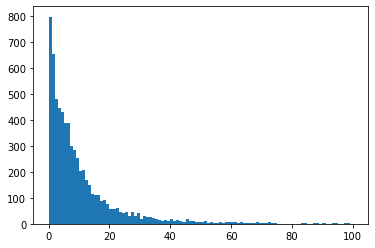

In [55]:
import matplotlib.pyplot as plt
plt.hist(ytrain,range=[0,100],bins=100)
print(ytrain.shape)
plt.savefig('weightfiter10.png')

In [56]:
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

In [57]:
weight = torch.randn((),device=device,dtype=torch.float,requires_grad=True).cuda()
learning_rate=0.001

In [58]:
ytrain.shape

(6672,)

In [143]:
plen=100
x_train = torch.from_numpy(xtrain).view(-1,plen,4).cuda()
y_train = torch.from_numpy(ytrain).view(-1,1).cuda()
x_test = torch.from_numpy(xtest).view(-1,plen,4).cuda()

In [144]:
batch_size=128
train_dataset = Data.TensorDataset(x_train[:5000],y_train[:5000])
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)
test_dataset = Data.TensorDataset(x_train[5000:],y_train[5000:])
test_loader = Data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

In [145]:
class Net(torch.nn.Module):
    def __init__(self, nfeature, out):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(nfeature,nfeature*4)
        self.fc2 = torch.nn.Linear(nfeature*4,nfeature*8)
        self.fc3 = torch.nn.Linear(nfeature*8,nfeature*8)
        self.fc = torch.nn.Linear(nfeature*4,out)
        self.conv1 = torch.nn.Conv1d(1,1,(1,3),padding=(0,1))
        self.fc4 = torch.nn.Linear(nfeature*8,nfeature*4)
    def forward(self, x):
        x = F.relu(self.hidden(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        x = F.relu(self.fc4(x))
        x = self.fc(x)
        #x = self.hidden(x)
        return x
model = Net(4,1).to(device)

In [146]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#criterion = nn.MSELoss()
criterion=nn.CrossEntropyLoss()

In [148]:
epochs = 64
for epoch in range(epochs):
    model.train()
    for batch,(x,y) in enumerate(train_loader):
        ypred = model(x.float())
        loss = criterion(ypred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    size = len(test_loader.dataset)
    test_loss, correct = 0,0
    with torch.no_grad():
        for x,y in test_loader:
            x = x.float()
            pred = model(x)
            test_loss += criterion(pred,y).item()
            correct += (pred.argmax(1) ==y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n')

Test Error: 
 Accuracy: 29.9%, Avg loss:0.019742 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019736 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019739 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019737 

Test Error: 
 Accuracy: 29.9%, Avg loss:0.019742 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019737 

Test Error: 
 Accuracy: 29.9%, Avg loss:0.019743 

Test Error: 
 Accuracy: 30.1%, Avg loss:0.019737 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019740 

Test Error: 
 Accuracy: 30.1%, Avg loss:0.019737 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019738 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019741 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019738 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019743 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019742 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019744 

Test Error: 
 Accuracy: 29.9%, Avg loss:0.019743 

Test Error: 
 Accuracy: 29.8%, Avg loss:0.019742 

Test Error: 
 Accuracy: 30.0%, Avg loss:0.019737 

Test Error: 
 Accuracy: 30.0%, 

In [137]:
torch.save(model.state_dict(),'itemFilter1.pth')

In [149]:
model.eval()
with torch.no_grad():
    x_test = x_test.float()
    predO = model(x_test)
    pred = np.argmax(predO.cpu().numpy(),axis=1)
realpred = [ytestreal[i,j] for i,j in enumerate(pred)]

In [240]:
x_test[1,:]

tensor([[0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [2., 1., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0.,

In [70]:
ytestreal[1,:]

array([   5024, 5700854, 5708653, 5729883, 5742717, 5753054, 5861100,
       5865793, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873653, 5873653, 5873653, 5873653, 5873653, 5873653,
       5873653, 5873

In [238]:
predO[1,:]

tensor([[ 1.0257],
        [ 1.0371],
        [ 0.6851],
        [ 1.0257],
        [ 1.0371],
        [ 3.2725],
        [ 1.0257],
        [ 1.0257],
        [ 0.6851],
        [ 1.2082],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.1767],
        [-0.

In [150]:
realpredict = pd.DataFrame({'user_id':sampleSubmit['user_id'],'product_id':np.array(realpred).reshape(-1)})

In [142]:
realpred.shape

AttributeError: 'list' object has no attribute 'shape'

In [72]:
sampleSubmit = pd.read_csv('./submit_example.csv')

In [151]:
realpredict.to_csv('itemTrainFilterFC4.csv',index=False)

In [103]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[ 5.2930e-01, -5.0948e-01, -3.5876e-01, -9.5217e-01],
        [-9.9876e-04, -1.8463e-01,  5.9240e-01,  3.0345e-01],
        [ 3.8832e-01,  7.5733e-01,  4.1641e-01,  4.1300e-01],
        [ 7.7947e-01,  2.1313e-01,  7.5113e-02,  2.8529e-01],
        [ 2.2845e-01,  1.5677e-02,  5.4855e-01,  5.8128e-01],
        [ 6.9522e-01, -1.1337e+00, -3.1509e-01,  4.7261e-01],
        [-5.0142e-01,  5.4254e-01,  4.0999e-01, -2.9368e-02],
        [-5.2682e-01, -8.6038e-01,  8.9790e-02, -8.4335e-01],
        [-4.7029e-01, -2.0466e-01, -3.1756e-02,  4.1276e-01],
        [ 7.2452e-01,  1.3759e-01, -3.2510e-01,  4.7051e-01],
        [-3.9757e-01, -3.7974e-01, -3.8528e-01, -3.7931e-01],
        [ 6.7556e-01,  8.0221e-01, -3.2118e-01, -1.9703e-01],
        [-6.9372e-01, -7.6724e-01, -8.1773e-01, -2.0252e-01],
        [-3.7680e-01,  3.7649e-01, -3.7060e-01,  7.4856e-01],
        [ 4.6577e-01, -2.2912e-01,  4.2377e-01,  4.6362e-01],
        [ 3.4392e-01,  7.6903e-01,  7.4900e-01, 